## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import copy

from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra

# Correct sequence fall off detection
We have a property in the program that lets us pass in a "truth" set. This truth set we will pull from Delong lab and will primarily be used for debugging our hybrids. The steps we need to take:
1. Load in SpectrumMill results and create a "truth" set where each entry in this json file has the form:
```json
{
    spectrum_id: {
        "sequence": str, 
        "hybrid": bool, 
        "parent": str
    }
}
```
2. Run hyped search with the "truth_set" param set to the file generated in step 1
3. Load in the file created (output_dir + 'fall_off.json')
4. Run all analysis

## Constants

In [2]:
spec_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredSpec/'
db_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredNOD2.fasta'
output_dir = '/Users/zacharymcgrath/Desktop/Experiment output/fall_off/'
specmil_truth_set = '/Users/zacharymcgrath/Downloads/NOD2_E3_results.ssv'

minPep = 3
maxPep = 30
tolerance = 20
relative_abundance_filter = 0.0
precursor_tolerance = 10
peak_filter = 25
verbose = True


## 1. Load in SpectrumMill and create truth file

In [3]:
# first load in the results
specmil_results = pd.read_csv(specmil_truth_set, sep=';')
specmil_results.head(5)


,number,filename,parent_charge,score,deltaForwardReverseScore,deltaRank1Rank2Score,percent_scored_peak_intensity,totalIntensity,previous_aa,sequence,next_aa,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,species,entry_name
0,1,NOD2_E3.13446.13477.2,2,10.10,10.10,9.91,84.5,183000.0,(E),DPQVEQLEL,(-),48.35,26.0,535.7725,MOUSE,ins1C18
1,2,NOD2_E3.18005.18246.2,2,12.84,11.07,12.84,97.8,40000000.0,(G),DLQTLALEVA,(-),65.78,29.0,536.8007,MOUSE,ins1C3
2,3,NOD2_E3.13729.13828.2,2,12.43,6.68,7.86,90.7,2200000.0,(G),DLQTLALE,(-),49.52,22.0,451.7460,MOUSE,ins1C5
3,4,NOD2_E3.15226.15503.2,2,11.17,6.21,6.67,89.1,1740000.0,(G),DLQTLAL,(-),54.38,169.0,387.2243,MOUSE,ins1C6
4,5,NOD2_E3.21510.21510.2,2,12.54,12.54,12.54,91.3,91900.0,(G),DLQTLALLL,(D),76.92,3.0,500.3081,MOUSE,HYBRID: mouse ins1C PQVEQLELGGSPGDLQTLAL-LLDEG...


In [4]:
def get_hybrid_seq(peptide: str, protein: str) -> str:
    '''
    From a hybrid protein that looks like 
    ABCDE-FGHI
    
    and a peptide that looks like
    DEFGH
    
    extract 
    DE-FGH
    
    Inputs:
        peptide: (str) the desired subseq
        protein: (str) the full string with the hybrid character 
    Outputs:
        new peptide string
    '''
    # copy the protein
    prot_cp = copy.deepcopy(protein)
    
    # find the subseq
    peptide_idx = protein.replace('-', '').replace('(', '').replace(')', '').index(peptide)
    
    # get that stretch of prot
    add_on = len(peptide) + (1 if '-' in protein else 2)
    
    return protein[peptide_idx:peptide_idx+add_on]

In [5]:
# json to store results in
json_truth_set = {}

# go through every entry in the database, find out if its a hybrid and get the sequence, ided by the filename
for idx, row in specmil_results.iterrows():
    
    # all the ids seem to have .pkl at the end of them so add that
    key = row['filename'] + '.pkl'
    hybrid = 'HYBRID' in row['entry_name']
    
    seq = row['sequence'] if not hybrid else get_hybrid_seq(row['sequence'], row['entry_name'])
    
    json_truth_set[key] = {
        'hybrid': hybrid, 
        'sequence': seq, 
        'parent': row['entry_name']
    }
    
full_truth_path = output_dir + 'specmil_truth_set.json'
    
json.dump(json_truth_set, open(full_truth_path, 'w'))

## 2. Run hypedsearch with the truth set

In [6]:
truth_run_params = {
    'spectra_folder': spec_file,
    'database_file': db_file,
    'output_dir': output_dir,
    'min_peptide_len': minPep,
    'max_peptide_len': maxPep,
    'tolerance': tolerance,
    'precursor_tolerance': precursor_tolerance,
    'peak_filter': peak_filter, 
    'relative_abundance_filter': relative_abundance_filter,
    'digest': 'trypsin', 
    'missed_cleavages': 2,
    'verbose': verbose,
    'DEBUG': False,
    'cores': 16,
    'truth_set': full_truth_path
}

runner.run(truth_run_params)


DEV set to True. 
Tracking when correct answer falls off. 
Results are stored in a json named 'fall_off.json' in the specified output directory
File will be of the form

    {
        spectrum_id: {
            hybrid: bool, 
            truth_sequence: str, 
            fall_off_operation: str, 
        }
    }
            
Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 280/280 [100%]
Sorting the set of protein masses...
Done
Initializing other processors...
Done.
Creating an alignment for 111/1086 [10%]other ope
Creating an alignment for 117/1086 [10%]ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
o

ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
Creating an alignment for 136/1086 [12%]ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope


opeope

opeope

ope
opeope

opeope
ope
ope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

ope
opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope
Creating an alignment for 151/1086 [13%]
opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

ope
ope
ope
opeope

opeope
ope

opeope

opeope

opeope

opeope

opeope

ope
opeope

ope
opeope

ope
opeope

opeope

opeope

opeope

opeope

ope
ope
opeope

opeope

ope
opeope
ope

ope
opeope
ope

opeope

ope
ope
opeope

opeope

opeope

opeope

opeope

opeope

opeope

ope
opeope
ope

opeope
ope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope
ope
ope

ope
ope
ope
opeope
ope
ope

opeope

opeope

ope
ope
opeope

opeope

ope
ope
opeope
ope

ope
opeope

opeope

ope
opeope

opeope

ope
ope
opeope

opeope

opeope



opeope

opeope

opeope

ope
ope
opeope

opeope

opeope

opeope

opeope
ope

ope
opeope

ope
ope
ope
ope
ope
ope
opeope

ope
ope
opeope
ope

ope
ope
opeope

opeope

opeope

opeope

ope
opeope

ope
opeope

ope
ope
ope
opeope
ope

opeope

ope
ope
opeope

opeope

ope
opeope
ope

opeope
ope

opeope

ope
opeope
ope

opeope

opeope

ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
ope
opeope

opeope

opeope

opeope

opeope

Creating an alignment for 164/1086 [15%]

opeope

opeope

opeope

opeope

opeope

opeope

opeope

ope
ope
ope
opeope

ope
opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

ope
ope
opeope

opeope

ope
opeope

ope
opeope

ope
ope
ope
ope
opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

ope
opeope

ope
opeope

ope
ope
opeope

opeope

opeope

opeope

ope
opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

opeope

ope
opeope

ope
opeope

opeope

ope
ope
ope
ope
ope
ope
ope
op

## 3. Load in the fall off results

In [7]:
fall_off_results = json.load(open(output_dir + 'fall_off.json'))
len(fall_off_results)

289

## 4. Run all analysis
### Plot the raw results

In [8]:
# first load them into dictionaries by {type: [seq]}
typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    typed_fall_off[entry['fall_off_operation']].append((_id, entry))
    

<BarContainer object of 5 artists>

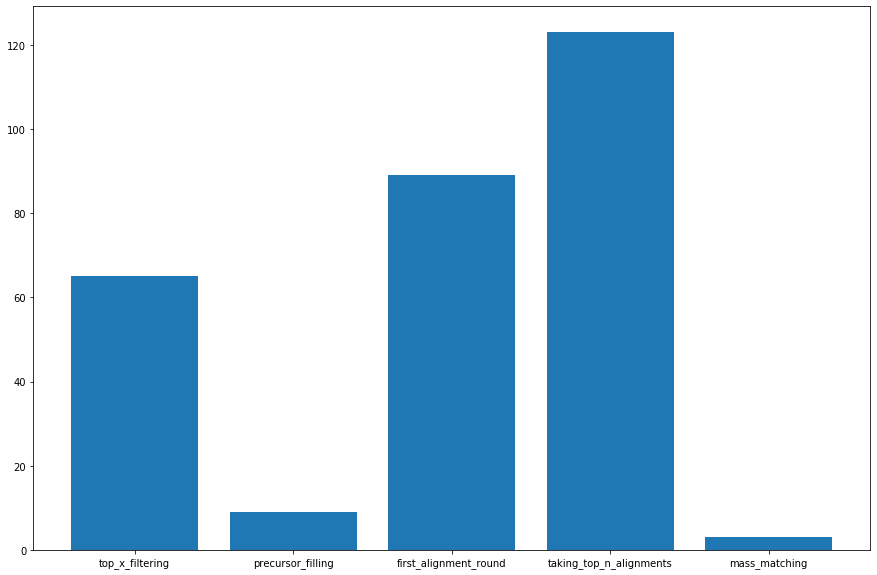

In [9]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)


### Just hybrid results

In [10]:
hybrid_typed_fall_off = defaultdict(list)
nonhybrid_typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    
    if entry['hybrid']:
        hybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))
        
    else:
        nonhybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))

Text(0.5, 1.0, 'Hybrid fall off positions')

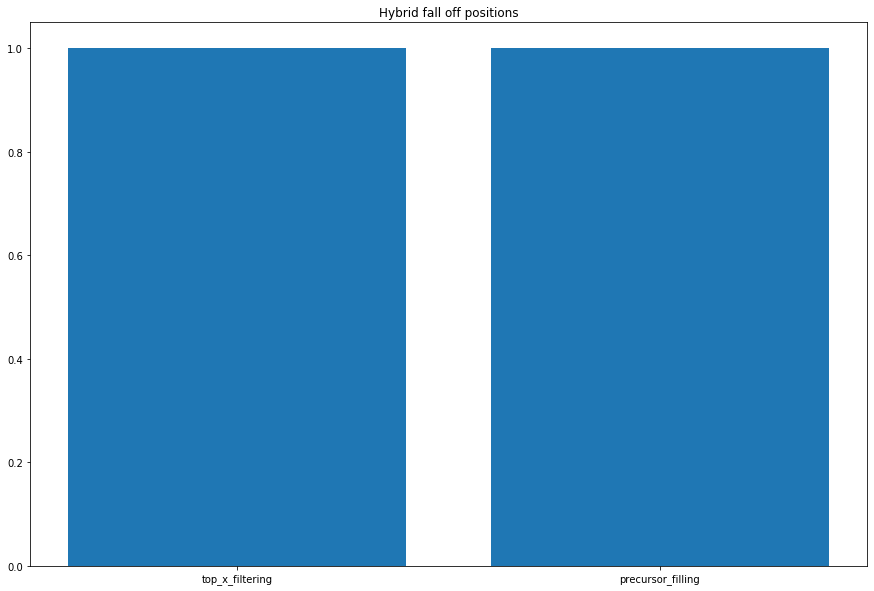

In [11]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(hybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Hybrid fall off positions')

Text(0.5, 1.0, 'Non hybrid fall off positions')

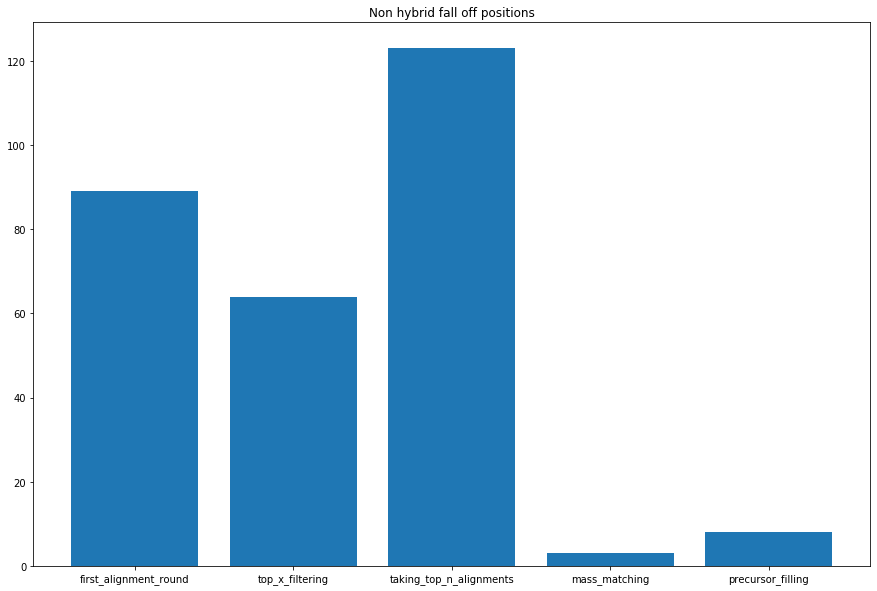

In [12]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(nonhybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Non hybrid fall off positions')

### Hybrid analysis

In [13]:
precursor_fall_offs = [x for x in hybrid_typed_fall_off['precursor_filling']]

In [14]:
for pfo in precursor_fall_offs:
    t_seq = pfo[1]['truth_sequence']
        
    print(f'Truth sequence: {t_seq}')
    print('Before\n===========================================')
    for x in pfo[1]['meta_data']['sequences_before_precursor_filling']:
        if x[0][:2] == t_seq[:2] and x[0][-2:] == t_seq[-2:]:
            print(x)
            
    print('After\n===========================================')
    for x in pfo[1]['meta_data']['sequences_after_precursor_filling']:
        if x[0][:1] == t_seq[:1] and x[0][-1:] == t_seq[-1:]:
            print(x)
            
    print()

Truth sequence: DLQTL-EVE
Before
['DLQTLPQVE', 'DLQTL-PQVE']
['DLQTLINPVE', 'DLQTL-INPVE']
['DLQTLFRNTNVE', 'DLQTL-FRNTNVE']
['DLQTLHTLDVE', 'DLQTL-HTLDVE']
['DLQTLAEPEEVE', 'DLQT(L)AEPEEVE']
['DLQTLPNVE', 'DLQTL-PNVE']
['DLQTLNPVE', 'DLQTL-NPVE']
['DLQTLGAPVE', 'DLQTL-GAPVE']
After



In [15]:
top_x_filtering = [x for x in hybrid_typed_fall_off['top_x_filtering']]

In [16]:
def is_close(truth, tried, ion, close_dist=2):
    if len(tried) > len(truth):
        return False
    
    if ion == 'b':
        return truth[:close_dist].replace('I', 'B').replace('L', 'B') == tried[:close_dist].replace('I', 'B').replace('L', 'B')
    else:
        return truth[-close_dist:].replace('I', 'B').replace('L', 'B') == tried[-close_dist:].replace('I', 'B').replace('L', 'B')
    
for _id, txf in top_x_filtering:
    t_seq = txf['truth_sequence']
    
    print(f'Truth sequence: {t_seq}')
    
    print('Kept b hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)

    print('Kept y hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print('Lost b hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)
            
    print('Lost y hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print()

Truth sequence: DLQTLAL-NAAR
Kept b hits close to correct half
DLQT
DLQDQL
Kept y hits close to correct half
Lost b hits close to correct half
DIQ
DLQ
DLQI
DIQI
DLQL
DLQNL
DIQVK
DIQVKE
Lost y hits close to correct half
ESKKAARAAR
NAAR
AARAAR
RAALAAR
EGPRCEVAAR
LCLALAWAAR



### Non hybrid analysis
#### Precursor filling

In [17]:
# get the precursor filling subjects
nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['precursor_filling']]

In [18]:
# go through every entry and find the sequences that were closest to the real sequence as possible
# closeness is: 
#   1. Having a lot of the right amino acids
#   2. Not have too many amino acids or too few
# Prioritize 1, rank by 2
def closeness(t_seq, trying, observed_precursor, observed_precursor_charge) -> (int, int):
    
    from_right = 0
    from_left = 0
    
    prec_distance = abs(gen_spectra.get_precursor(trying, observed_precursor_charge) - observed_precursor)
    
    # first check if they ARE the same
    if t_seq == trying:
        return (len(t_seq), 0, prec_distance)
    
    # go from left to right
    i = 0
    while i < len(t_seq) and i < len(trying) and t_seq[i] == trying[i]:
        i += 1
        from_left += 1
        
    # now right to left
    i = -1
    while abs(i) < len(t_seq) + 1 and abs(i) < len(trying) + 1 and t_seq[i] == trying[i]:
        i -= 1
        from_right += 1
        
    return (from_left + from_right, abs(len(t_seq) - len(trying)), prec_distance)

for _id, nhpfo in nh_precursor_fall_off:
    
    # get the real sequence
    t_seq = nhpfo['truth_sequence']
    
    # keep track of the best of the close ones 
    overlapped_idxed_close_hits = defaultdict(list)
    
    observed_prec = nhpfo['meta_data']['observed_precursor_mass']
    observed_prec_charge = nhpfo['meta_data']['observed_percursor_charge']
    
    for non_hyb, hyb in nhpfo['meta_data']['sequences_before_precursor_filling']:
        overlap, dist, prec_dist = closeness(t_seq, non_hyb, observed_prec, observed_prec_charge)
        overlapped_idxed_close_hits[overlap].append((non_hyb, hyb, dist, prec_dist))
        
    # now get the hightest key
    best_key = max(list(overlapped_idxed_close_hits.keys()))
    
    # show the best results sorted by their distance
    print(f'({_id}) Hits with the most overlap ({best_key} AAs) for sequence {t_seq} with allowed gap {nhpfo["meta_data"]["allowed_gap"]}')
    print('=====================================================================================')
    for seq, hyb_seq, dist, prec_distance in sorted(overlapped_idxed_close_hits[best_key], key=lambda x: x[2]):
        print(f'{seq} \t {dist} \t {prec_distance} \t {hyb_seq}')
        
    print()
    

(NOD2_E3.16717.16754.5.pkl) Hits with the most overlap (24 AAs) for sequence DGNGTIDFPEFLTMMARKMKDTDSEEEIR with allowed gap 11
IDFPEFLTMMARKMKDTDSEEEIR 	 5 	 88.83209105999993 	 None

(NOD2_E3.3735.3735.4.pkl) Hits with the most overlap (17 AAs) for sequence DVNRTLEGGRKPLHYAA with allowed gap 7
DVNRTLEGGRKPLHYA 	 1 	 17.760777674999986 	 None

(NOD2_E3.13448.13448.2.pkl) Hits with the most overlap (12 AAs) for sequence DEDNTWEPEENL with allowed gap 5
SDEDNTWEPEENL 	 1 	 43.51597775000005 	 None

(NOD2_E3.18250.18282.6.pkl) Hits with the most overlap (41 AAs) for sequence DEWMRIILEALRQAENEPPSAPKENKPYALNLEKNFPVDTP with allowed gap 15
SEDEWMRIILEALRQAENEPPSAPKENKPYALNLEKNFPVDTP 	 2 	 36.010517016666995 	 None

(NOD2_E3.6083.6083.2.pkl) Hits with the most overlap (12 AAs) for sequence DPLNPIKQ with allowed gap 4
DPLNDPLNPIKQ 	 4 	 219.5981902499999 	 DPLN-DPLNPIKQ

(NOD2_E3.21225.21225.4.pkl) Hits with the most overlap (28 AAs) for sequence DVDPELLRYLLGRILTGSSEPEAAPAP with allowed gap 10
D

#### Taking the top n alignments

In [19]:
top_n = nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['taking_top_n_alignments']]

In [20]:
for _id, top_n_spec in top_n:
    t_seq = top_n_spec['truth_sequence']
    
    print(f'Top n alignments for sequence {t_seq}')
    print('============================================================')
    print('sequence \t b score \t y score \t total score \t precursor distance \t hybrid')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]} \t {"hybrid_sequence" in x}') for x in top_n_spec['meta_data']['top_n']]
    
    print('------------------------------------------------------------')
    print('Missed alignments for this sequence')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]} \t {"hybrid_sequence" in x}') for x in top_n_spec['meta_data']['not_top_n'][:10]]
    print('------------------------------------------------------------')
    all_alignments = [x for x in top_n_spec['meta_data']['top_n']] + [x for x in top_n_spec['meta_data']['not_top_n']]
    num_hyb = len([0 for x in all_alignments if 'hybrid_sequence' in x])
    p_hyb = int(100 * (float(num_hyb) / float(len(all_alignments))))
    scores = [x['total_score'] for x in all_alignments]
    avg_score = np.mean(scores)
    min_score = min(scores)
    
    print(f'Stats: \t Number alignments: {len(all_alignments)} \t % hybrid: {p_hyb} \t Average score: {avg_score} \t min score: {min_score}')
    print()

Top n alignments for sequence EVRKALSRQEMQEVQSSRSGRGGNFGFG
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
ACRNLFGPVNHEGHRAVPAASYGRIYAGGG 	 3 	 3 	 4.5 	 0.0002288600001065788 	 True
ACRNLFGPVNWITLCIGEYSLIVNTATE 	 3 	 3 	 4.5 	 0.0037677399998301553 	 True
PPSYITQPEDPLGHRAVPAASYGRIYAGGG 	 3 	 3 	 4.5 	 0.00385833999996521 	 True
ACRNLFGPVNDAIYKEFSFKNFNQAFG 	 3 	 3 	 4.5 	 0.0061630600000626146 	 True
LPLDTDKGVHYISVSAATSEEQIKEYFG 	 2 	 4 	 4.5 	 0.001345540000102119 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
LEGQCNPDLRLLGVARYNSYQSFQTPQ 	 2 	 3 	 4.5 	 0.002743060000057085 	 True
SWCRAATLGHRAVPANRGGCEQRCLNTLG 	 2 	 3 	 4.5 	 0.003907260000119095 	 True
EEVRKNKESKDPANMIEVHKDTDLSKG 	 2 	 2 	 4 	 0.005711539999765591 	 False
EVRKALSRQEMQEVQSSRSGRGGNFGFG 	 0 	 4 	 4 	 0.00094893999983014

Missed alignments for this sequence
------------------------------------------------------------
TVAKSIDLKPAAAFR 	 3 	 2 	 4.0 	 0.0015496750000352222 	 True
ALPRFLTQPYIIR 	 3 	 2 	 4.0 	 0.002262324999946941 	 True
EFIAWLVKGRGRR 	 0 	 3 	 3 	 0.0012154250000548927 	 False
TFAKKHGRLRFAR 	 2 	 3 	 3.0 	 0.0015930749999597538 	 True
TFGGLRVRHLLYR 	 2 	 2 	 3.0 	 0.0012174250000498432 	 True
TFNLRVRHLLYR 	 2 	 2 	 3.0 	 0.0012176750000776337 	 True
TFNIRVRHLLYR 	 2 	 2 	 3.0 	 0.0012176750000776337 	 True
LAALCIQGRLRFAR 	 2 	 3 	 2.5 	 0.0003724250000232132 	 True
TTRRPTGRLRFAR 	 2 	 3 	 2.5 	 0.0005875749999972868 	 True
WAVIPKSLEYLLR 	 2 	 2 	 2.5 	 0.0005464250000386528 	 True
------------------------------------------------------------
Stats: 	 Number alignments: 33 	 % hybrid: 84 	 Average score: 2.742424242424242 	 min score: 1.5

Top n alignments for sequence DLSLEEIQKKLEAA
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------

EVIITPNLLVVN 	 3 	 1 	 3.5 	 0.0011714249999386084 	 True
EVIITPLRALQA 	 3 	 1 	 3.5 	 0.0016373250000469852 	 True
------------------------------------------------------------
Stats: 	 Number alignments: 52 	 % hybrid: 90 	 Average score: 2.9711538461538463 	 min score: 1

Top n alignments for sequence DILNVLGME
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
EVINVLGME 	 5 	 4 	 9 	 0.0006462499999315696 	 False
EVNLVLGME 	 5 	 4 	 9 	 0.0006462499999315696 	 False
QVVDILGME 	 5 	 4 	 8.5 	 0.000645749999932832 	 True
VQVEVLGME 	 5 	 4 	 8.5 	 0.000645749999932832 	 True
NIVEVLGME 	 5 	 4 	 8.5 	 0.0006462499999315696 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
LNVEVLGME 	 5 	 4 	 8.5 	 0.0006462499999315696 	 True
INVEVLGME 	 5 	 4 	 8.5 	 0.0006462499999315696 	 True
DLVQVLGME 	 

SSGPTNPGLVNK 	 2 	 2 	 4 	 0.0008556999999882464 	 False
SAAAENPGLVNK 	 2 	 2 	 4 	 0.0008556999999882464 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
SDARNVGLPEL 	 2 	 2 	 4 	 0.0008556999999882464 	 False
SSPSGQRIPEL 	 2 	 2 	 4 	 0.0008557000001019333 	 False
SSASPNPGLVNK 	 2 	 2 	 4 	 0.0008560333333207382 	 False
SDDLIHIVMK 	 2 	 2 	 4 	 0.0016089666666516678 	 False
SDLDIHIVMK 	 2 	 2 	 4 	 0.0016089666666516678 	 False
SDARNVLGNPK 	 2 	 2 	 4 	 0.0028886333333275616 	 False
SDNARRLLEP 	 2 	 2 	 4 	 0.0028886333333275616 	 False
SDARNPGLVNK 	 2 	 2 	 4 	 0.002888633333384405 	 False
TGNDRRLLEP 	 2 	 2 	 4 	 0.00288896666660321 	 False
DDPELRQGIK 	 1 	 3 	 4 	 0.0008553666667125981 	 False
------------------------------------------------------------
Stats: 	 Number alignments: 136 	 % hybrid: 88 	 Average score: 2.702205882352941 	 min score: 1.5

Top n alignmen

DGGPDIFLHSL 	 4 	 5 	 9 	 0.0016792500000519794 	 False
DGGPDIFLSHL 	 4 	 4 	 8 	 0.0016792500000519794 	 False
DGGPDIFISHI 	 4 	 4 	 8 	 0.0016792500000519794 	 False
DNDPIFLHIS 	 4 	 4 	 8 	 0.0016797499999938736 	 False
DGGPDIFIHSI 	 4 	 5 	 8.0 	 0.0016792500000519794 	 True
DNDPIFLSHL 	 4 	 3 	 6.5 	 0.0016797499999938736 	 True
DNDPIFISHI 	 4 	 3 	 6.5 	 0.0016797499999938736 	 True
DGDPGIFLHIS 	 3 	 4 	 6.0 	 0.0016792500000519794 	 True
DGDPGLFLHIS 	 3 	 4 	 6.0 	 0.0016792500000519794 	 True
------------------------------------------------------------
Stats: 	 Number alignments: 63 	 % hybrid: 74 	 Average score: 3.738095238095238 	 min score: 0

Top n alignments for sequence DRVLYVLKLY
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KQGGLYVLKLY 	 5 	 5 	 10 	 0.0009873666666635472 	 False
KQNLYVLKLY 	 5 	 5 	 10 	 0.0009876999999391955 	 False
KNQLYVLKLY 	 5 	 5 	 10 	 0.0009877000000528824 

#### first alignment round

In [21]:
first_as = [x for x in nonhybrid_typed_fall_off['first_alignment_round']]

In [22]:
def most_aa_overlap(truth, trying):
    overlap = 0
    
    if truth == trying:
        return len(truth)
    
    i = 0
    while i < len(truth) and i < len(trying) and trying[i] == truth[i]:
        i += 1
        overlap += 1
        
    i = -1
    while i > -1 * min(len(trying), len(truth)) and truth[i] == trying[i]:
        i -= 1
        overlap += 1
        
    return overlap - max(0, len(trying) - len(truth))

for _id, fa in first_as:
    
    t_seq = fa['truth_sequence']
    
    most_overlap = defaultdict(list)
    for non_hyb, hyb in fa['meta_data']['alignments']:
        most_overlap[most_aa_overlap(t_seq, non_hyb)].append((non_hyb, hyb))
        
    most_aas = max(list(most_overlap.keys()))
    closest_matches = most_overlap[most_aas]
    
    
    print(f'({_id}) Closest alignments to sequence {t_seq} at overlap {most_aas}')
    print('=================================================================')
    [print(f'{non_hyb} \t {hyb}') for non_hyb, hyb in closest_matches]
    print()
    

(NOD2_E3.13446.13477.2.pkl) Closest alignments to sequence DPQVEQLEL at overlap 6
DPQVESFCL 	 DPQVE-SFCL
DPQVEQLEAYCL 	 DPQVEQLE-AYCL
DPQVEQLNNPEL 	 DPQVEQL-NNPEL
DPQVEQLHICL 	 DPQVEQL-HICL
DPQVEHICL 	 DPQVE-HICL
DPQVEQLSFCL 	 DPQVEQL-SFCL
DPQVEQLAYCL 	 DPQVEQL-AYCL
DPQVEQLEHICL 	 DPQVEQLE-HICL
DPQVEQLEFSCL 	 DPQVEQLE-FSCL
DPQVEQNNPEL 	 DPQVEQ-NNPEL
DPQVEQLFSCL 	 DPQVEQL-FSCL
DPQVEAYCL 	 DPQVE-AYCL
DPQVEQLTCI 	 DPQVEQ(L)TCI
DPQVEQLELTCI 	 DPQVEQLE-LTCI
DPQVEQFSCL 	 DPQVEQ-FSCL
DPQVENNPEL 	 DPQVE-NNPEL
DPQVEQLTCI 	 DPQVEQ-LTCI
DPQVEQHICL 	 DPQVEQ-HICL
DPQVEQAYCL 	 DPQVEQ-AYCL
DPQVEQLESFCL 	 DPQVEQLE-SFCL
DPQVEQLENNPEL 	 DPQVEQLE-NNPEL
DPQVEQSFCL 	 DPQVEQ-SFCL
DPQVEFSCL 	 DPQVE-FSCL

(NOD2_E3.15226.15503.2.pkl) Closest alignments to sequence DLQTLAL at overlap 5
DLQTLALFWAL 	 DLQTLA-LFWAL
DLQTPTAL 	 DLQT-PTAL
DLQTLFWAL 	 DLQT-LFWAL
DLQTLAPTAL 	 DLQTLA-PTAL

(NOD2_E3.18005.18246.2.pkl) Closest alignments to sequence DLQTLALEVA at overlap 7
DLQTLALDPGVA 	 DLQTLAL-DPGVA
DLQTLADPGVA 	 DLQTLA

DGEEAMVSWRMEDPL 	 DGEEAM-VSWRMEDPL
DGEEAMVFQKYSGKDGNNTQL 	 DGEEAM-VFQKYSGKDGNNTQL
DGEEAMTNTQSPTSLPS 	 DGEEAM-TNTQSPTSLPS
DGEEAMSVKDMSPS 	 DGEEAM-SVKDMSPS
DGEEAMGFFYTPKS 	 DGEEAM-GFFYTPKS
DGEEAMPNSDGSLLGS 	 DGEEAM-PNSDGSLLGS
DGEEAMRIDHETRPAKGEDSS 	 DGEEAM-RIDHETRPAKGEDSS
DGEEAMSNKWEVPS 	 DGEEAM-SNKWEVPS
DGEEAMPASLPSSGSGS 	 DGEEAM-PASLPSSGSGS

(NOD2_E3.18871.18910.2.pkl) Closest alignments to sequence DFMAALEAEPY at overlap 9
DFMAALEAEST 	 DFMAAL(EAE)ST
DFMAALEMDPY 	 DFMAALE-MDPY
DFMAALEAEST 	 DFMAAL(EA)EST
DFMAALEAEMDPY 	 DFMAALEAE-MDPY
DFMAALEAEST 	 DFMAAL-EAEST
DFMAALEAMDPY 	 DFMAALEA-MDPY
DFMAALEAEST 	 DFMAAL(E)AEST

(NOD2_E3.20155.20196.3.pkl) Closest alignments to sequence DDIVGETVEKTEFIPLL at overlap 14
DDIVGETVEKTERGKPLL 	 DDIVGETVEKTE-RGKPLL
DDIVGETVEKTEFRGKPLL 	 DDIVGETVEKTEF-RGKPLL

(NOD2_E3.19855.19855.2.pkl) Closest alignments to sequence DGKALEQFLQEYF at overlap 10
DGKALEQFLQEGKVEYF 	 DGKALEQFLQE-GKVEYF
DGKALEQFLGKVEYF 	 DGKALEQFL-GKVEYF
DGKALEQFLQEVVSYF 	 DGKALEQFLQE-VVSYF

(NOD2_E3.3433.3433.4.pkl) Closest alignments to sequence DMEEEQAFKRSRNT at overlap 12
EDMEEEQAFKRSRNT 	 None

(NOD2_E3.9571.9605.3.pkl) Closest alignments to sequence DEMVESMKKVAGM at overlap 11
YDEMVESMKKVAGM 	 None

(NOD2_E3.6198.6286.5.pkl) Closest alignments to sequence DKHLIPAANTGESKVFYYKMKG at overlap 5
DKHLILYRR 	 DKHLI-LYRR
DKHLIFRVVS 	 DKHLI-FRVVS
DKHLIFNKA 	 DKHLI-FNKA
DKHLIATGGSGDELLGITA 	 DKHLI-ATGGSGDELLGITA
DKHLILRYR 	 DKHLI-LRYR
DKHLITIA 	 DKHLI-TIA
DKHLIKNFAK 	 DKHLI-KNFAK
DKHLIRYRI 	 DKHLI-RYRI
DKHLIRRYI 	 DKHLI-RRYI
DKHLIFRALT 	 DKHLI-FRALT
DKHLIRRLY 	 DKHLI-RRLY
DKHLIMPSESAAQSLAVA 	 DKHLI-MPSESAAQSLAVA
DKHLILGRVY 	 DKHLI-LGRVY
DKHLIYLRR 	 DKHLI-YLRR
DKHLIGLLHPA 	 DKHLI-GLLHPA
DKHLILPIHQ 	 DKHLI-LPIHQ
DKHLIFTRA 	 DKHLI-FTRA
DKHLIYRIR 	 DKHLI-YRIR
DKHLILVAAPH 	 DKHLI-LVAAPH
DKHLILRRY 	 DKHLI-LRRY
DKHLILLPHQ 	 DKHLI-LLPHQ
DKHLILLAAERTIGAQA 	 DKHLI-LLAAERTIGAQA
DKHLILTAFR 	 DKHLI-LTAFR
DKHLIWKPA 	 DKHLI-WKPA
DKHLITA 	 DKHL(I)TA
DKHLIRFTA 	 DKHLI-RFTA
DKHLIIRKQREEAA 	 DKH

(NOD2_E3.13798.13962.6.pkl) Closest alignments to sequence DLRLENVQKFPSPEMIRALEYIEKLRQQAHRE at overlap 12
DLRLENVQKFPAEAKSPIEVKSPE 	 DLRLENVQKF-PAEAKSPIEVKSPE
DLRLENVQKFGKLTGPSNQKRE 	 DLRLENVQKF-GKLTGPSNQKRE
DLRLENVQKFIQERAWLRE 	 DLRLENVQK(F)IQERAWLRE

(NOD2_E3.4802.4883.3.pkl) Closest alignments to sequence EVLKVLGNPKS at overlap 9
KLLKVLGNPKS 	 KL(LK)VLGNPKS
KILKVLGNPKS 	 KI(LK)VLGNPKS
KLLKVLGNPKS 	 KLL(K)VLGNPKS
KILKVLGNPKS 	 KIL(K)VLGNPKS
AEVLKVLGNPKS 	 None

(NOD2_E3.7782.7782.3.pkl) Closest alignments to sequence DVMRALGQNPTNA at overlap 10
DVMRALGQNPTNGYPA 	 DVMRALGQNPTN-GYPA
DVMRALGQNPTGYPA 	 DVMRALGQNPT-GYPA
DVMRALGQNSVPA 	 DVMRALGQN-SVPA
DVMRALGQNVSPA 	 DVMRALGQN-VSPA
DVMRALGQNPGYPA 	 DVMRALGQNP-GYPA
DVMRALGQNPVSPA 	 DVMRALGQNP-VSPA
DVMRALGQNPTNVSPA 	 DVMRALGQNPTN-VSPA
DVMRALGQNPTSVPA 	 DVMRALGQNPT-SVPA
DVMRALGQNGYPA 	 DVMRALGQN-GYPA
DVMRALGQNPTVSPA 	 DVMRALGQNPT-VSPA
DVMRALGQNPSVPA 	 DVMRALGQNP-SVPA
DVMRALGQNPTNSVPA 	 DVMRALGQNPTN-SVPA

(NOD2_E3.12024.12089.4.pkl) Closest al

(NOD2_E3.16470.16470.3.pkl) Closest alignments to sequence DARPAMAATSFVLMTTFPNKELA at overlap 22
DARPAMAATSFVLMTTFPNKELAH 	 DARPAMAATSFVLMTTFPNK(E)LAH
DARPAMAATSFVLMTTFPNKELHA 	 DARPAMAATSFVLMTTFPNK(E)LHA
DARPAMAATSFVLMTTFPNKEHLA 	 DARPAMAATSFVLMTTFPNK(E)HLA
DARPAMAATSFVLMTTFPNKEHLA 	 DARPAMAATSFVLMTTFPNKE-HLA

(NOD2_E3.19651.19651.3.pkl) Closest alignments to sequence DVPTLTGAFGILASHVPTLQVLRPGLVVVHTE at overlap 30
VDVPTLTGAFGILASHVPTLQVLRPGLVVVHTE 	 None

(NOD2_E3.3569.3569.3.pkl) Closest alignments to sequence EQVKSIKELG at overlap 8
KKVKSIKELG 	 KK-VKSIKELG
HEQVKSIKELG 	 None
SEQVKSIKELG 	 None
TTVKSIKELG 	 TT-VKSIKELG

(NOD2_E3.14907.14949.4.pkl) Closest alignments to sequence DFTPENYKRIEAIVKNYPEGHQAAAVLPVL at overlap 28
FDFTPENYKRIEAIVKNYPEGHQAAAVLPVL 	 None

(NOD2_E3.14898.14939.5.pkl) Closest alignments to sequence DFTPENYKRIEAIVKNYPEGHQAAAVLPVL at overlap 28
FDFTPENYKRIEAIVKNYPEGHQAAAVLPVL 	 None

(NOD2_E3.21475.21475.3.pkl) Closest alignments to sequence DELMAELEELEQEEL at ove